# Beta Bank: predicting customers drop-off

Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.

Using the data on clients’ past behavior and termination of contracts with the bank, this project is aimed at predicting whether a customer will leave the bank soon. The dataset contains the following information:

``Features``

    - RowNumber — data string index

    - CustomerId — unique customer identifier

    - Surname — surname

    - CreditScore — credit score
    
    - Geography — country of residence
    
    - Gender — gender
    
    - Age — age
    
    - Tenure — period of maturation for a customer’s fixed deposit (years)

    - Balance — account balance
    
    - NumOfProducts — number of banking products used by the customer

    - HasCrCard — customer has a credit card

    - IsActiveMember — customer’s activeness
    
    - EstimatedSalary — estimated salary

``Target``

    - Exited — сustomer has left

In this case, we are dealing with a classification supervised learning task with only two possible answers: exited = 1 (True) or 0 (False).

For assesing model quality, we will focus on two classification metrics:

F1 score: this metric combines **precision** and **recall**, which evaluate the quality of predictions of the positive class from different angles:

- Recall describes how well the model understood the properties of this class and how well it recognized the class. 

    **RECALL = TRUE POSTIVES [TP] / (TRUE POSITIVES [TP] + FALSE NEGATIVES [FN])**


- Precision detects whether the model is overdoing it by assigning too many positive labels.
    
    **PRECISION = TRUE POSTIVES [TP] / (TRUE POSITIVES [TP] + FALSE POSITIVES [FP])**
    
    
Both metrics are important. Aggregating metrics — one of which is the F1 score — help to control them simultaneously. This is the harmonic mean of recall and precision. In F1, 1 means that the ratio of recall to precision is 1:1.

   **F1 = 2 x PRECISION x RECALL / (PRECISION + RECALL)**
   

We will focus in building a model with the **maximum possible F1 score**, which must be at least 0.59. 

F1 will be checked for the test set.


Finally, we'll measure the **AUC-ROC (Area Under Curve-Receiver Operating Characteristic)** metric and compare it with the F1. 

The ROC curve can be plotted by putting the false positive rate values (FPR) along the horizontal axis, and true positive rate values (TPR) along the vertical axis. Then we iterate over the logistic regression threshold values (the value starting from which the predicted value will be set as 1=True) and plot a curve. 

For a model that always answers randomly, the ROC curve is a diagonal line going from the lower left to the upper right. The higher the curve, the greater the TPR value and the better the model's quality.


The AUC-ROC value will allow us to find how much our model differs from the random model. Its values are always in the range from 0 to 1. The AUC-ROC value for a random model is 0.5.
  


## 1) Import libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 


from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## 2) Load the dataset into a dataframe

In [2]:
# Load companies data into a Dataframe
try:
    df=pd.read_csv('c:/Users/josef/Practicum/Supervised learning/Churn.csv')
except:
    df=pd.read_csv('/datasets/Churn.csv')

## 3) Open and look through the data file

In [3]:
#Print first five rows
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
#Print general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
#print duplicates
df.duplicated().sum()

0

In [6]:
#Print sum of missing values per column
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


## Conclusion

From an overall data view, we can tell that before getting the dataset ready to start developing the model we must:

- 1) Rename columns using lowercase characters, and switching to the snake_case format. We will only select numeric columns that will be effectively used for training the model and making predictions. This means, we'll get rid of "RowNumber", "CustomerId" and "Surname".

- 2) Fix missing values in ``tenure``. Recall from the description that the column stores the period of maturation for a customer’s fixed deposit (years).


There are no duplicates, or data types to be changed.

In [7]:
#Select useful columns only

df= df.loc[:,'CreditScore':]
df.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1341,794,France,Female,41,7.0,176845.41,3,1,0,166526.26,1
3499,617,France,Male,74,10.0,0.00,2,1,1,53949.98,0
1687,850,Spain,Male,37,4.0,137204.77,1,1,1,28865.59,0
9678,635,Spain,Male,29,2.0,0.00,2,0,0,117173.80,0
4389,660,France,Male,30,7.0,146301.31,1,0,0,96847.91,0


In [8]:
#Rename columns:
#switch to lowercase
df= df.rename(columns={column: column.lower() for column in df.columns})

#separate words with underscores
df= df.rename(columns={'creditscore': 'credit_score', 'numofproducts': 'num_of_products', 'hascrcard':'has_cr_card','isactivemember':'is_active_member','estimatedsalary':'estimated_salary' })

In [9]:
#check replacement
df.columns

Index(['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance',
       'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited'],
      dtype='object')

In [10]:
#assess percentage of missing values

missing_values=df['tenure'].isna().sum()/len(df)

print(f'Missing values represent {missing_values:.2%} of the dataset')

Missing values represent 9.09% of the dataset


Since there is more than a 5% of missing values, we won't drop the rows. We will try to find out if it's reasonable to replace them the mean or median tenure.

In [11]:
#Get description of column. Compare the mean and the median for replacing missing values
df['tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

The mean and median tenure are almost the same. We'll use the median to fill missing values.

In [12]:
#Fill missing values using the median
median_tenure= df['tenure'].median()
df['tenure'].fillna(median_tenure,inplace= True)



In [13]:
#Check replacement
df['tenure'].describe()

count    10000.00000
mean         4.99790
std          2.76001
min          0.00000
25%          3.00000
50%          5.00000
75%          7.00000
max         10.00000
Name: tenure, dtype: float64

## 4) Assess Balance and Imbalance of the Classes

Below, we will check how often the target feature contains the class "1" or "0". In the event that there is a significant imbalance (the ratio is far from 1:1), we will apply upsampling or downsampling to balance the results.


    

0    0.7963
1    0.2037
Name: exited, dtype: float64


<AxesSubplot:>

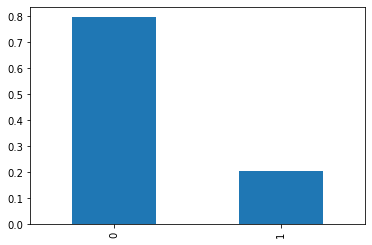

In [14]:
#Print and plot percentages of users who exited vs. those who did not exit
class_frequency= df['exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

The ratio is 4:1, so we conclude that classes are unbalanced.

## 5) Train the model without taking into account the imbalance

First, we will train three different types of models without balancing classes and assess the results.

    

### Logistic regressor

We'll start by training a logistic regression model. 

To begin with, we'll transform categorical features (Geography and gender) into numerical features. We will use One-hot encoding, provided that Label Encoding is a bad idea for regression algorithms. Such algorithms are based on learning weights for each feature in a formula. Hence, if we encode a categorical variable with numbers in a single column, then the algorithm will treat the variable as continuous and assume the values are on a meaningful scale.

So in case of regression, the categories have to be encoded in a way that assigns equal importance to all of them, yet still lets them be recognized as distinct and different. That's why OHE (One Hot Encoding) is necessary in the first place. OHE encodes each category as a linearly independent vector in N-dimensional space. All such vectors are initially equidistant from each other, and will learn their separate independent weights during the algorithm's execution. That's why OHE performs well for all machine learning algorithms that look at all the features at the same time during training.

To avoid the high correlation between encoded columns confusing our model, we can safely remove any one column, since its values can be easily inferred from the other two columns (it has 1 where the other two columns have zeroes, and it has zeroes everywhere else). This way, we will not fall into the dummy trap. This can be achieved by passing "drop_first=True" into the encoding formula.

    

In [15]:
#One-hot encode data

df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [16]:
#Separate features and target

target= df_ohe['exited']
features_ohe= df_ohe.drop(['exited'], axis=1)


#Split the source data into three sets using the ratio of 60:20:20

features_train_ohe, features_test_ohe, target_train,target_test = train_test_split(features_ohe, target, test_size=0.20,random_state=12345)
features_train_ohe, features_valid_ohe, target_train,target_valid = train_test_split(features_train_ohe, target_train, test_size=0.25,random_state=12345)

#check data was split correctly into train, valid and test
print(len(features_train_ohe)/len(df_ohe))
print(len(features_valid_ohe)/len(df_ohe))
print(len(features_test_ohe)/len(df_ohe))


0.6
0.2
0.2


In [17]:
#Standarize feature scaling

scaler = StandardScaler()
scaler.fit(features_train_ohe) 

features_train_ohe_scaled= scaler.transform(features_train_ohe)
features_valid_ohe_scaled= scaler.transform(features_valid_ohe)

In [18]:
#Create regression model
model_regression= LogisticRegression(random_state=12345, solver='liblinear')

#Train regression model
model_regression.fit(features_train_ohe_scaled, target_train)

#Store predictions
predicted_valid = model_regression.predict(features_valid_ohe_scaled)

#Store probabilities assigned by the model
probabilities_valid = model_regression.predict_proba(features_valid_ohe_scaled)

#Store probabilities of class "1" (exited)
probabilities_one_valid = probabilities_valid[:, 1]



print(f'Precision score: {precision_score(target_valid, predicted_valid)}')
print(f'Recall score: {recall_score(target_valid, predicted_valid)}')
print(f'F1 score: {f1_score(target_valid, predicted_valid)}')
print(f'AUC-ROC: {roc_auc_score(target_valid, probabilities_one_valid)}\n\n')
print(f'Confusion matrix:\n[[True Negative, False Positive]\n[False Negative, True Positive]]')
print(confusion_matrix(target_valid, predicted_valid))

Precision score: 0.574468085106383
Recall score: 0.2071611253196931
F1 score: 0.30451127819548873
AUC-ROC: 0.7703169034793099


Confusion matrix:
[[True Negative, False Positive]
[False Negative, True Positive]]
[[1549   60]
 [ 310   81]]


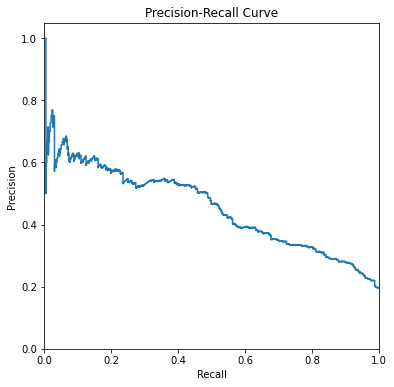

In [19]:
#Plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show() 


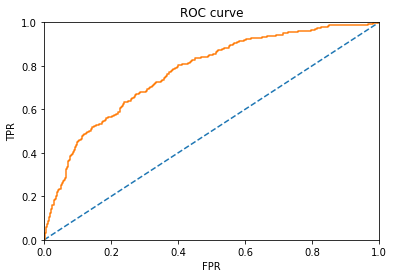

In [20]:
#Plot the ROC Curve for the regression model vs. for random model

fpr, tpr, thresh = roc_curve(target_valid,probabilities_one_valid)

plt.clf()
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < plot the graph >
plt.plot(fpr, tpr)

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >


plt.xlabel('FPR')
plt.ylabel('TPR')

# < add the heading "ROC curve" with the function plt.title() >
plt.title('ROC curve')
plt.show()


### Tree-based models: Decision Tree & Random Forest

Now we'll train and score a decision tree and a random forest. For categorical columns, we'll change the encoding method.

One-hot encoding is not the best option for tree-based models for a few reasons. The primary reason is that unlike regression models that have access to the whole spectrum of features at once, the tree-based model can process only one feature at a time. As a result, it doesn't have complete information about the original categorical variable. Instead, its importance is dispersed across many dummy variables, so these dummy variables are almost never chosen as splitting variables near the root of the tree, even if they were a good predictor.

The best approach for trees is making splits by raw categoricals, but since scikit-learn does not currently support this option, in many cases, the second best approach turns out to be Label Encoding.

The drawbacks of Label Encoding are mitigated by the fact that for trees, while the order of labels still matters, the scale of labels doesn't. In other words, there's no real difference between labels [0, 1, 2, 3] and labels [0, 2, 5, 40]. And thanks to that, even though Label Encoding still creates information that does not reflect any real facts and sometimes results in splits that don't make any sense, practical applications show that it still often results in useful splits, especially when several random permutations of numeric labels are tried.

For that same reason, we don't need to standarize data neither.

Provided that neither gender nor geography have any kind of implicit natural order, we won't use ordinal encoding.

In [21]:
#store categorical columns

cat_col=[col for col in df.columns if df[col].dtype=='object' ]

# Label encode data
encoder = OrdinalEncoder() 
encoder.fit(df[cat_col]) 
df_ordinal = pd.DataFrame(encoder.transform(df[cat_col]),columns=cat_col) 
df_ordinal.head()

,geography,gender
0,0.0,0.0
1,2.0,0.0
2,0.0,0.0
3,0.0,0.0
4,2.0,0.0


In [22]:
#list with non categorical columns
non_cat_col=[col for col in df.columns if df[col].dtype!='object' ]

#join with non categorical columns
df_ordinal=df[non_cat_col].join( df_ordinal).copy()
df_ordinal.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography,gender
0,619,42,2.0,0.00,1,1,1,101348.88,1,0.0,0.0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,2.0,0.0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0.0,0.0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0.0,0.0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,2.0,0.0


In [23]:
#Separate features and target

target= df_ordinal['exited']
features_ordinal= df_ordinal.drop(['exited'], axis=1)

#Split the source data three sets using the ratio of 60:20:20

features_train_ordinal, features_test_ordinal, target_train,target_test = train_test_split(features_ordinal, target, test_size=0.20,random_state=12345)
features_train_ordinal, features_valid_ordinal, target_train,target_valid = train_test_split(features_train_ordinal, target_train, test_size=0.25,random_state=12345)



In [24]:
#Define decision tree model
model_tree= DecisionTreeClassifier(random_state=12345, max_depth= 5)


#Train decision tree model
model_tree.fit(features_train_ordinal, target_train)

#Store predictions
predicted_valid = model_tree.predict(features_valid_ordinal)

#Store probabilities assigned by the model
probabilities_valid = model_tree.predict_proba(features_valid_ordinal)

#Store probabilities of class "1" (exited)
probabilities_one_valid = probabilities_valid[:, 1]


print(f'Precision score: {precision_score(target_valid, predicted_valid)}')
print(f'Recall score: {recall_score(target_valid, predicted_valid)}')
print(f'F1 score: {f1_score(target_valid, predicted_valid)}')
print(f'AUC-ROC: {roc_auc_score(target_valid, probabilities_one_valid)}')

print(f'Confusion matrix:\n[[True Negative, False Positive]\n[False Negative, True Positive]]')
print(confusion_matrix(target_valid, predicted_valid))


Precision score: 0.7416267942583732
Recall score: 0.39641943734015345
F1 score: 0.5166666666666666
AUC-ROC: 0.8207159535795295
Confusion matrix:
[[True Negative, False Positive]
[False Negative, True Positive]]
[[1555   54]
 [ 236  155]]


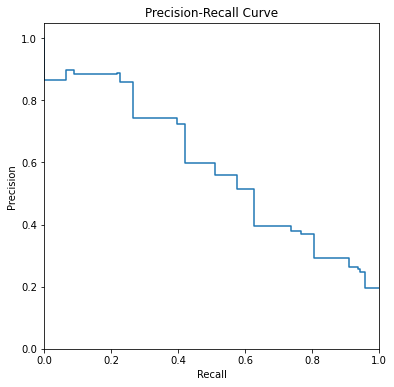

In [25]:
#Plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show() 


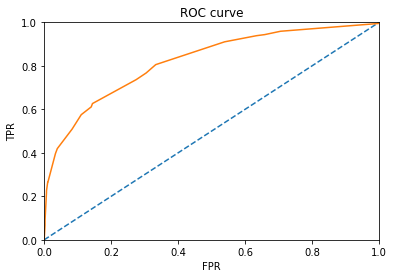

In [26]:
#Plot the ROC Curve for the regression model vs. for random model

fpr, tpr, thresh = roc_curve(target_valid,probabilities_one_valid)

plt.clf()
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < plot the graph >
plt.plot(fpr, tpr)

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >

plt.xlabel('FPR')
plt.ylabel('TPR')

# < add the heading "ROC curve" with the function plt.title() >
plt.title('ROC curve')
plt.show()


In [27]:
#Define random forest model
model_forest= RandomForestClassifier(random_state=12345, max_depth= 5, n_estimators=5)

#Train decision tree model
model_forest.fit(features_train_ordinal, target_train)

#Store predictions
predicted_valid = model_forest.predict(features_valid_ordinal)

#Store probabilities assigned by the model
probabilities_valid = model_forest.predict_proba(features_valid_ordinal)

#Store probabilities of class "1" (exited)
probabilities_one_valid = probabilities_valid[:, 1]



print(f'Precision score: {precision_score(target_valid, predicted_valid)}')
print(f'Recall score: {recall_score(target_valid, predicted_valid)}')
print(f'F1 score: {f1_score(target_valid, predicted_valid)}')
print(f'AUC-ROC: {roc_auc_score(target_valid, probabilities_one_valid)}')
print(f'Confusion matrix:\n[[True Negative, False Positive]\n[False Negative, True Positive]]')
print(confusion_matrix(target_valid, predicted_valid))



Precision score: 0.8074534161490683
Recall score: 0.33248081841432225
F1 score: 0.47101449275362317
AUC-ROC: 0.8217880877862535
Confusion matrix:
[[True Negative, False Positive]
[False Negative, True Positive]]
[[1578   31]
 [ 261  130]]


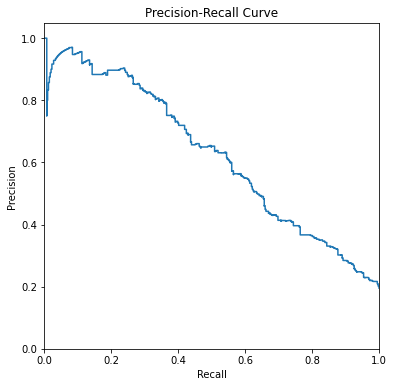

In [28]:
#Plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show() 


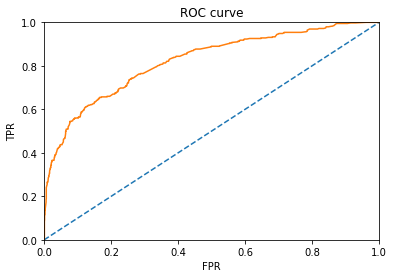

In [29]:
#Plot the ROC Curve for the regression model vs. for random model

fpr, tpr, thresh = roc_curve(target_valid,probabilities_one_valid)

plt.clf()
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < plot the graph >
plt.plot(fpr, tpr)

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >


plt.xlabel('FPR')
plt.ylabel('TPR')

# < add the heading "ROC curve" with the function plt.title() >
plt.title('ROC curve')
plt.show()



Precision is 0.57, 0.74 and 0.80, meaning that the respective percentages of positives predicted were correct [TP/(TP+FP)]. Recall is lower (0.21, 0.40 and 0.33) mainly due to false negatives increasing the denominator [TP/(TP+FN)]. This is more likely because of samples where class is "0" being 4 times more frequent than those of class 1, what causes every algorithm to overestimate the probability of the target being negative (0). 

From the confusion matrixes, we can see that models are rather pesimistic, as they often see negative answers when they shouldn't (False negatives). Decision tree is the one getting the lowest count of false negative predictions. Also, it got the best F1 score (most balanced relationship between precision and recall) and has the highest ROC curve. Still, since the F1 score is below the minimum established (0.52 vs 0.59), we will need to improve the model quality and fix the class imbalance to successfully achieve our goal.

As for the AUC-ROC score, the tree-based models got the highest result as well, achieving a 0.82 score, and the logistic regression one fell behind, scoring 0.77.



## 6) Improve the model quality

Now, we will fix the class imbalance using three different approaches and re-assess the quality of the models using the F1 score:

**1) class_weight argument**

The logistic regression, decision trees and random forests algorithms in the sklearn library have the class_weight argument. By default, it is None — i.e., classes are equivalent:

class "0" weight = 1.0

class "1" weight = 1.0

If we specify class_weight='balanced', the algorithm will calculate how many times the class "0" occurs more often than the class "1". We’ll denote this number as N (an unknown number of times). The new class weights look like this:

class "0" weight = 1.0

class "1" weight = N

The rare class will have a higher weight.

**2) Upsampling: repeating the samples with the rarest class result (exited=1)**

Upsampling is performed in several steps:

- Split the training sample into negative and positive observations;

- Duplicate the positive observations several times;

- Create a new training sample based on the data obtained;

- Shuffle the data: identical questions following one another will not help the training.

**3) Downsampling: removing a part of the most frequent class.**

Downsampling is performed in several steps:

- Split the training sample into negative and positive observations;

- Randomly drop a portion of the negative observations;

- Create a new training sample based on the data obtained;

- Shuffle the data. Make sure the positive data doesn't follow the negative data: this will make it harder for the algorithms to learn.


Next, we'll use the training and validation sets to pick the best parameters. 

Finally, we'll assess performance on the test set, ensuring we achieve the 0.59 F1 score required.

#### 6.1) class_weight adjustment


    

#####  6.1.a) class_weight adjustment  Logistic regressor   

In [30]:
#Create regression model
model_regression= LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')

#Train regression model
model_regression.fit(features_train_ohe_scaled, target_train)

#Store predictions
predicted_valid = model_regression.predict(features_valid_ohe_scaled)

#Store probabilities assigned by the model
probabilities_valid = model_regression.predict_proba(features_valid_ohe_scaled)

#Store probabilities of class "1" (exited)
probabilities_one_valid = probabilities_valid[:, 1]



print(f'F1 score: {f1_score(target_valid, predicted_valid)}')

print(confusion_matrix(target_valid, predicted_valid))

F1 score: 0.4767857142857143
[[1147  462]
 [ 124  267]]


#####  6.1.b) class_weight adjustment:  Decision tree

In [31]:
#Pick best parameters based on predictions made on the train set
f1_score_tree=0
model_tree=None

for depth in range(1,15,1):
    model= DecisionTreeClassifier(random_state=12345, max_depth= depth, class_weight='balanced')

    #Train decision tree model
    model.fit(features_train_ordinal, target_train)

    #Store predictions on the train set
    predicted_valid = model.predict(features_valid_ordinal)

  
    #calculate f1 score
    
    f1_score_model = f1_score(target_valid, predicted_valid)
    
    #store the model with the highest result
    if f1_score_model >f1_score_tree:
        
        model_tree= model
        f1_score_tree= f1_score_model



print(f'F1 score: {f1_score_tree}')

print(f'Best model parameters: {model_tree}')

F1 score: 0.5638766519823788
Best model parameters: DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)


#####  6.1.b) class_weight adjustment:  Random forest

In [32]:
#Pick best parameters based on predictions made on the train set
f1_score_forest=0
model_forest=None
estimators=0
for est in (80,100,10):

    for depth in range(1,15,1):
        model= RandomForestClassifier(random_state=12345, max_depth= depth, n_estimators=est, class_weight='balanced')

        #Train decision tree model
        model.fit(features_train_ordinal, target_train)

        #Store predictions on the train set
        predicted_valid = model.predict(features_valid_ordinal)


        #calculate f1 score

        f1_score_model = f1_score(target_valid, predicted_valid)

        #store the model with the highest result
        if f1_score_model >f1_score_forest:

            model_forest= model
            f1_score_forest= f1_score_model
            estimators=est


print(f'F1 score: {f1_score_forest}')

print(f'Best model parameters: {model_forest}, n_estimators: {estimators}')

F1 score: 0.5807327001356852
Best model parameters: RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=80,
                       random_state=12345), n_estimators: 80


#### 6.2) Upsampling
    

#####  6.2.a) Upsampling: Logistic regressor   

In [33]:
#Define function to upsample


def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [34]:
#Upsample, increasing the repetiton of positive answers by 4 (recall that the ratio is 4:1)
features_train_upsampled_ohe, target_train_upsampled = upsample(
    features_train_ohe, target_train, 4
)


#Standarize feature scaling
scaler = StandardScaler()
scaler.fit(features_train_upsampled_ohe) 

features_train_upsampled_ohe_scaled= scaler.transform(features_train_upsampled_ohe)


In [35]:
#Create regression model
model_regression= LogisticRegression(random_state=12345, solver='liblinear')

#Train regression model
model_regression.fit(features_train_upsampled_ohe_scaled,target_train_upsampled)

#Store predictions
predicted_valid = model_regression.predict(features_valid_ohe_scaled)

#Store probabilities assigned by the model
probabilities_valid = model_regression.predict_proba(features_valid_ohe_scaled)

#Store probabilities of class "1" (exited)
probabilities_one_valid = probabilities_valid[:, 1]



print(f'F1 score: {f1_score(target_valid, predicted_valid)}')


F1 score: 0.46617647058823536


#####  6.2.b) Upsampling: Decision Tree 

In [36]:
#Upsample, increasing the repetiton of positive answers by 4 (recall that the ratio is 4:1)
features_train_upsampled_ordinal, target_upsampled = upsample(
    features_train_ordinal, target_train, 4
)


In [37]:
#Pick best parameters based on predictions made on the train set
f1_score_tree=0
model_tree=None

for depth in range(1,15,1):
    model= DecisionTreeClassifier(random_state=12345, max_depth= depth)

    #Train decision tree model
    model.fit(features_train_upsampled_ordinal, target_upsampled)

    #Store predictions on the train set
    predicted_valid = model.predict(features_valid_ordinal)

  
    #calculate f1 score
    
    f1_score_model = f1_score(target_valid, predicted_valid)
    
    #store the model with the highest result
    if f1_score_model >f1_score_tree:
        
        model_tree= model
        f1_score_tree= f1_score_model



print(f'F1 score: {f1_score_tree}')

print(f'Best model parameters: {model_tree}')

F1 score: 0.5638766519823788
Best model parameters: DecisionTreeClassifier(max_depth=6, random_state=12345)


#####  6.2.c) Upsampling: Random forest

In [38]:
#Pick best parameters based on predictions made on the train set
f1_score_forest=0
model_forest=None
estimators=0
for est in (80,100,10):

    for depth in range(1,25,1):
        model= RandomForestClassifier(random_state=12345, max_depth= depth, n_estimators=est)

        #Train decision tree model
        model.fit(features_train_upsampled_ordinal, target_upsampled)

        #Store predictions on the train set
        predicted_valid = model.predict(features_valid_ordinal)


        #calculate f1 score

        f1_score_model = f1_score(target_valid, predicted_valid)

        #store the model with the highest result
        if f1_score_model >f1_score_forest:

            model_forest= model
            f1_score_forest= f1_score_model
            estimators=est


print(f'F1 score: {f1_score_forest}')

print(f'Best model parameters: {model_forest}, n_estimators={estimators}')

F1 score: 0.5885057471264369
Best model parameters: RandomForestClassifier(max_depth=10, random_state=12345), n_estimators=100


#### 6.3) Downsampling
    

#####  6.3.a) Downsampling: Logistic regressor   

In [39]:
#Define function to reduce the repetition of the samples with the most frequent result (exited=0)

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [40]:

#Upsample, increasing the repetiton of positive answers by 4 (recall that the ratio is 4:1)
features_train_downsampled_ohe, target_train_downsampled = downsample(
    features_train_ohe, target_train, 0.25
)


#Standarize feature scaling
scaler = StandardScaler()
scaler.fit(features_train_downsampled_ohe) 

features_train_downsampled_ohe_scaled= scaler.transform(features_train_downsampled_ohe)
features_valid_ohe_scaled= scaler.transform(features_valid_ohe)

In [41]:
#Create regression model
model_regression= LogisticRegression(random_state=12345, solver='liblinear')

#Train regression model
model_regression.fit(features_train_downsampled_ohe_scaled, target_train_downsampled)

#Store predictions
predicted_valid = model_regression.predict(features_valid_ohe_scaled)

#Store probabilities assigned by the model
probabilities_valid = model_regression.predict_proba(features_valid_ohe_scaled)

#Store probabilities of class "1" (exited)
probabilities_one_valid = probabilities_valid[:, 1]


print(f'F1 score: {f1_score(target_valid, predicted_valid)}')



F1 score: 0.4727592267135325


#####  6.3.b) Downsampling: Decision Tree 

In [42]:
#Downsample, reducing the repetiton of positive answers by 4 (recall that the ratio is 4:1)
features_train_ordinal_downsampled, target_train_downsampled = downsample(
    features_train_ordinal, target_train, 0.25
)


In [43]:
#Pick best parameters based on predictions made on the train set
f1_score_tree=0
model_tree=None

for depth in range(1,15,1):
    model= DecisionTreeClassifier(random_state=12345, max_depth= depth)

    #Train decision tree model
    model.fit(features_train_ordinal_downsampled, target_train_downsampled)

    #Store predictions on the train set
    predicted_valid= model.predict(features_valid_ordinal)

  
    #calculate f1 score
    
    f1_score_model = f1_score(target_valid, predicted_valid)
    
    #store the model with the highest result
    if f1_score_model >f1_score_tree:
        
        model_tree= model
        f1_score_tree= f1_score_model



print(f'F1 score: {f1_score_tree}')

print(f'Best model parameters: {model_tree}')

F1 score: 0.5272145144076841
Best model parameters: DecisionTreeClassifier(max_depth=6, random_state=12345)


#####  6.3.c) Downsampling: Random forest

In [44]:
#Pick best parameters based on predictions made on the train set
f1_score_forest=0
model_forest=None
estimators=0
for est in (80,100,10):

    for depth in range(1,25,1):
        model= RandomForestClassifier(random_state=12345, max_depth= depth, n_estimators=est)

        #Train decision tree model
        model.fit(features_train_ordinal_downsampled, target_train_downsampled)

        #Store predictions on the train set
        predicted_valid = model.predict(features_valid_ordinal)


        #calculate f1 score

        f1_score_model = f1_score(target_valid, predicted_valid)

        #store the model with the highest result
        if f1_score_model >f1_score_forest:

            model_forest= model
            f1_score_forest= f1_score_model
            estimators=est


print(f'F1 score: {f1_score_forest}')

print(f'Best model parameters: {model_forest}, n_estimators={estimators}')

F1 score: 0.5671641791044776
Best model parameters: RandomForestClassifier(max_depth=7, random_state=12345), n_estimators=100


**CONCLUSION: WE ACHIEVED THE HIGHEST F1 SCORE (0.59) ON THE VALIDATION SET, USING THE UPSAMPLING METHOD ON A RANDOM FOREST CLASSIFIER WITH THE FOLLOWING HYPERPARAMETERS:**


** RandomForestClassifier(max_depth=10, random_state=12345), n_estimators=100: F1 score= 0.59**


**Results summary:**


***class_weight adj:***


Logistic regressor: F1 score= 0.48

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345): F1 score= 0.56

RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=100, random_state=12345):F1 score= 0.58


***Upsampling:***


Logistic regressor: F1 score= 0.47

DecisionTreeClassifier(max_depth=6, random_state=12345): F1 score= 0.56

RandomForestClassifier(max_depth=13, n_estimators=100, random_state=12345): F1 score= 0.59


***Downsampling:***


Logistic regressor: F1 score= 0.47

DecisionTreeClassifier(max_depth=6, random_state=12345): F1 score= 0.53

RandomForestClassifier(max_depth=10, n_estimators=100, random_state=12345): F1 score= 0.57


## 7) Perform the final testing.

Now that we have selected the best performing model and class balancing technique using the train & validation sets to train the model, and the test set to assess the f1 score achieved.



In [45]:

#Separate features and target (Ordinal encoding)

target= df_ordinal['exited']
features_ordinal= df_ordinal.drop(['exited'], axis=1)


#Split the source data into three sets using the ratio of 60:20:20

features_train_ordinal, features_test_ordinal, target_train,target_test = train_test_split(features_ordinal, target, test_size=0.20,random_state=12345)



#Upsample, increasing the repetiton of positive answers by 4 (recall that the ratio is 4:1)
features_train_ordinal_upsampled, target_train_upsampled = upsample(
   features_train_ordinal, target_train, 4
)

#Define the final model
final_model= RandomForestClassifier(max_depth=10, n_estimators=100, random_state=12345)

#train the final model using the 
final_model.fit(features_train_ordinal_upsampled, target_train_upsampled)

#make predictions on the test set

predicted_test= final_model.predict(features_test_ordinal)

#Store probabilities assigned by the model
probabilities_test = model_forest.predict_proba(features_test_ordinal)

#Store probabilities of class "1" (exited)
probabilities_one_test = probabilities_test[:, 1]



print(f'Precision score: {precision_score(target_test, predicted_test)}')
print(f'Recall score: {recall_score(target_test, predicted_test)}')
print(f'F1 score: {f1_score(target_test, predicted_test)}')
print(f'AUC-ROC: {roc_auc_score(target_test, probabilities_one_test)}')
print(f'Confusion matrix:\n[[True Negative, False Positive]\n[False Negative, True Positive]]')
print(confusion_matrix(target_test, predicted_test))



Precision score: 0.5706214689265536
Recall score: 0.7096018735362998
F1 score: 0.6325678496868475
AUC-ROC: 0.8617448125644847
Confusion matrix:
[[True Negative, False Positive]
[False Negative, True Positive]]
[[1345  228]
 [ 124  303]]


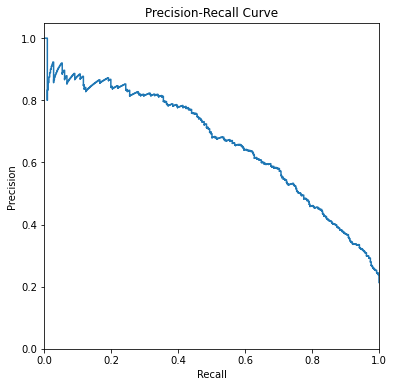

In [46]:
#Plot the precision recall curve
precision, recall, thresholds = precision_recall_curve(
    target_test, probabilities_one_test
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show() 


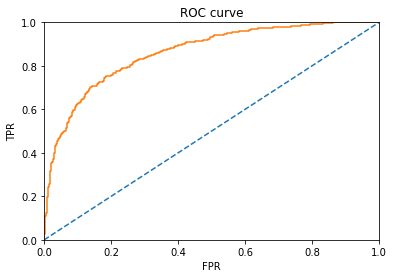

In [47]:
#Plot the ROC Curve for the regression model vs. for random model

fpr, tpr, thresh = roc_curve(target_test,probabilities_one_test)

plt.clf()
# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

# < plot the graph >
plt.plot(fpr, tpr)

# < use the functions plt.xlim() and plt.ylim() to
#   set the boundary for the axes from 0 to 1 >
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

# < use the functions plt.xlabel() and plt.ylabel() to
#   name the axes "False Positive Rate" and "True Positive Rate" >


plt.xlabel('FPR')
plt.ylabel('TPR')

# < add the heading "ROC curve" with the function plt.title() >
plt.title('ROC curve')
plt.show()



### CONCLUSION 

After importing the dataset, fixing missing values, renaming columns, and removing those that didn't contain observations with any potential impact on the customer exiting the bank or not (Surname, row nº, and Customer ID), we detected classes were unbalanced, with the negative class (0- did not exit) being 4 times more frequent than the positive class (1-exited). 

Before balancing the classes, we built a Linear Regressor, Decision tree and Random Forest model and after encoding categorical columns (using OHE for regression and Label encoding for tree-based models), we used the training and validation set (the original dataset was split into train set (60%), validation set(20%) and test set (20%)) to calculate Precision, recall, F1 score and AUC-ROC score. We also plotted the ROC curve as compared to that of the random model, and the PR curve (precision-recall).

Provided that the classes were unbalanced, we achieved a high precision but recall was too low as to allow F1 score to be above the minimum set for accepting the model (0.59). This is due to them being too pesimistic as a consequence of having seen too many negative answers, and therefore making negative predictions where they shouldn't (False negatives were too high [RECALL = TP/(TP+FN)].

Moving forward, we proceeded to tackle class imbalance trying three different methods: class_weight='balanced', upsampling and downsampling.

Employing the train and validation set, we calculated the f1 score achieved by each of the models (tunning hyperparameters to get the highest possible score in tree-based models), and managed to find out that the Random Forest Regressor with 100 estimators and a max_depth of 10, did pass the 0.59 F1 score for the test set when balacing classes through the "Upsampling" method (since the ratio of negative:positive was 4:1, we increased the positive class 4 times)

The final step was to use that model and balancing method to make predictions on the test set. The F1 score turned out to be 0.63, and the AUC-ROC (0.86) also improved as compared to that achieved by the models trained before balancing classes, meaning that the area under curve is greater than the one of the random model (0.50).


